In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.calibration import calibration_curve 
from sklearn.metrics import brier_score_loss
from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier
import lifelines

from sklearn.model_selection import GridSearchCV


In [2]:
X = catalog.load("X")
y = catalog.load("y")
cat_cols = catalog.load("params:cat_cols")

data = pd.concat([X, y], axis=1)

[11/26/23 14:08:43] INFO     Loading data from 'X' (CSVDataSet)...                              ]8;id=823863;file:///home/ricardormotta/projects/LTV_analysis/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=329712;file:///home/ricardormotta/projects/LTV_analysis/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'y' (CSVDataSet)...                              ]8;id=585846;file:///home/ricardormotta/projects/LTV_analysis/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=154203;file:///home/ricardormotta/projects/LTV_analysis/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'params:cat_cols' (MemoryDataset)...             ]8;id=711495;file:///home/ricardormotta/projects/LTV_analysis/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=120198;file:///home/ricardormotta/projects/LTV_analysis/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

In [3]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
T = data.loc[:, "days_to_churn"]
E = data.loc[:, "is_churn"]
kmf.fit(T, event_observed=E)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 102623 total observations, 64065 right-censored observations>

<Axes: xlabel='timeline'>

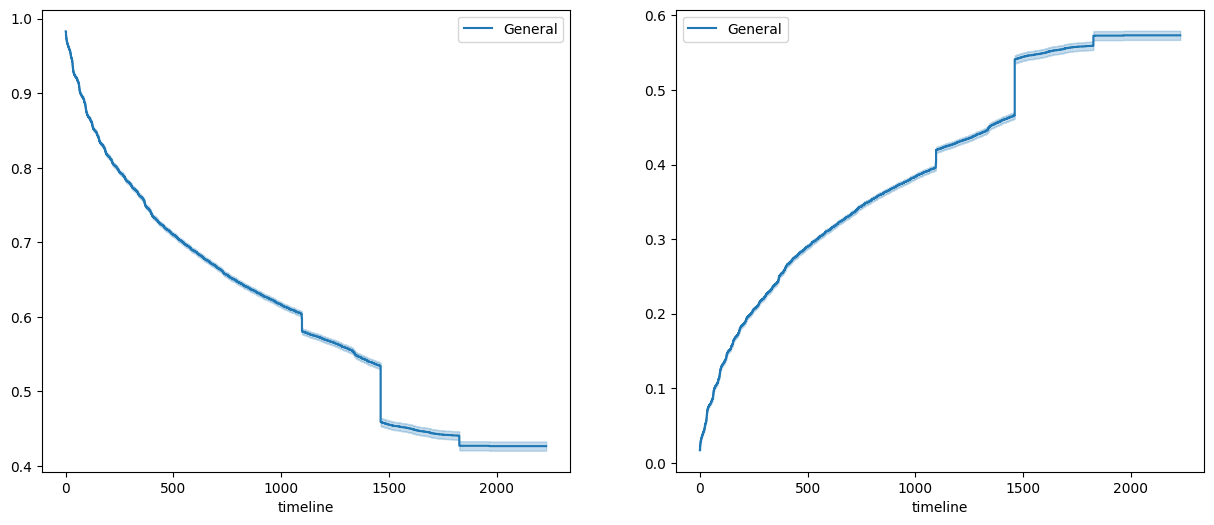

In [4]:
kmf.survival_function_
kmf.cumulative_density_
fig, axs = plt.subplots(1,2, figsize=(15,6))
kmf.plot_survival_function(ax=axs[0], label="General")
kmf.plot_cumulative_density(ax = axs[1], label="General")

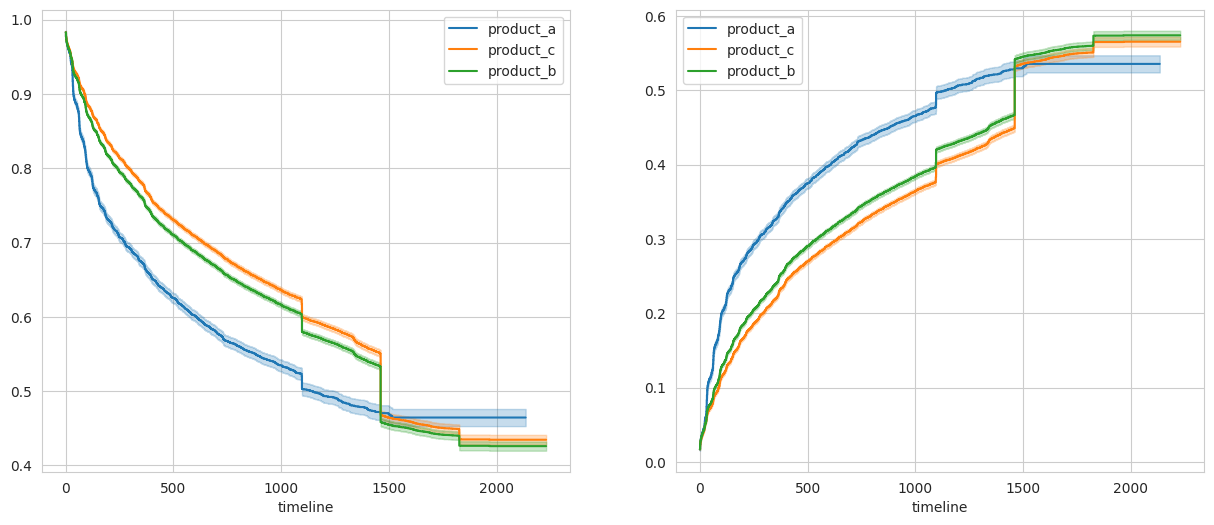

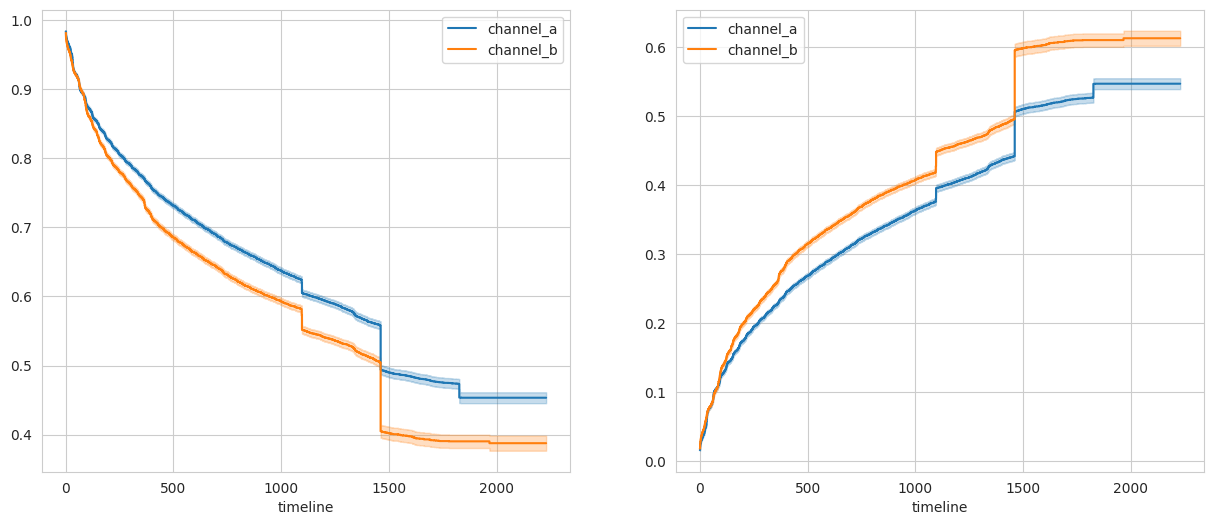

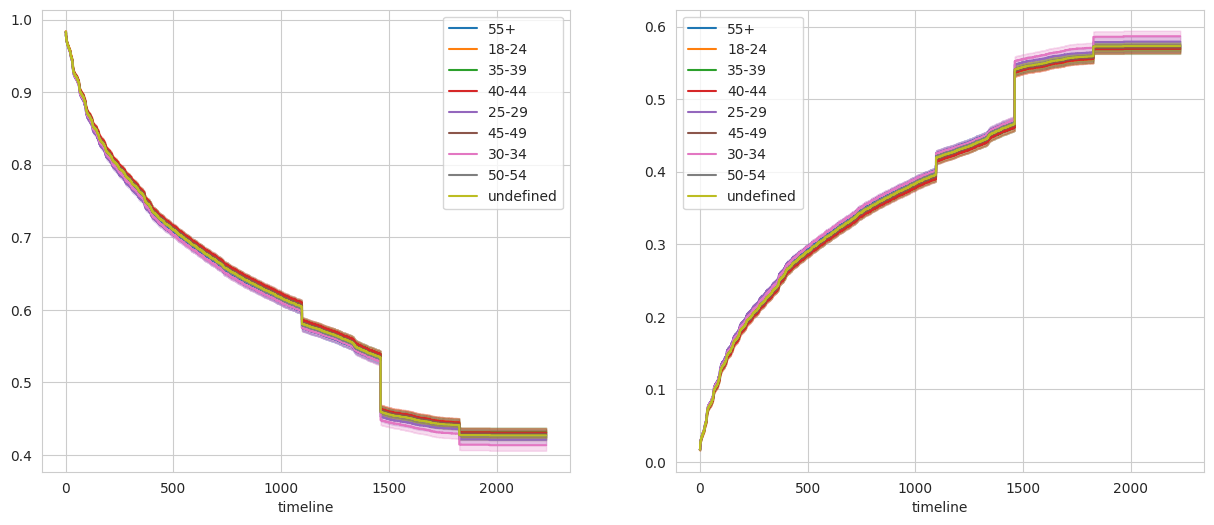

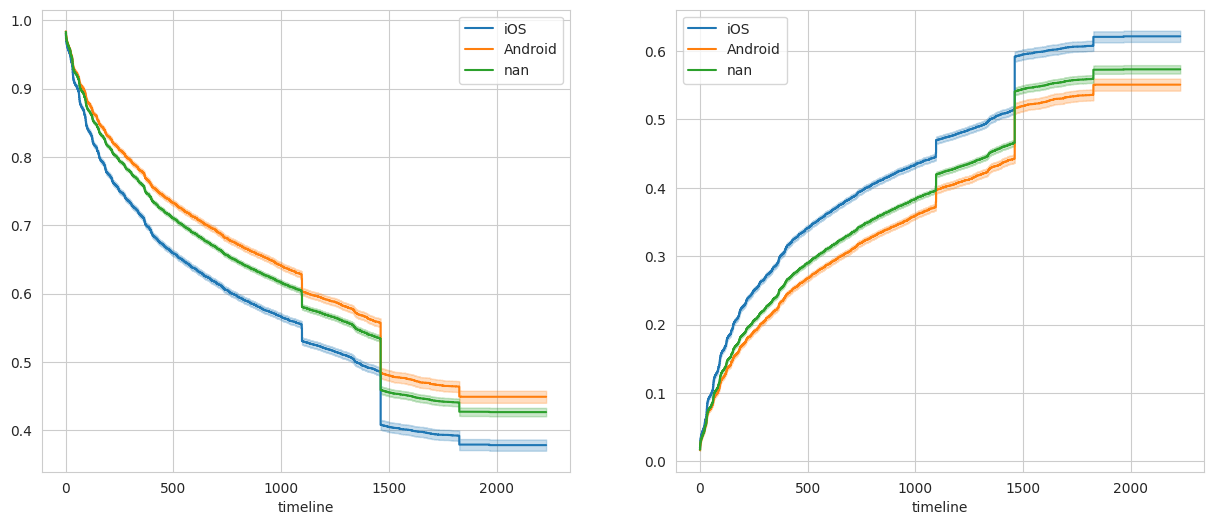

In [5]:
group_cols = ["product", "channel", "age_bucket", "operating_system"]
sns.set_style("whitegrid")
for group_col in group_cols:
    fig, axs = plt.subplots(1,2, figsize=(15,6))
    for group in data[group_col].unique():
        groups = data[group_col]
        ix = (groups == group)
        kmf.fit(T[~ix], E[~ix], label=group)
        kmf.plot_survival_function(ax=axs[0])
        kmf.plot_cumulative_density(ax = axs[1])
    plt.show()

In [6]:
num_cols = ["days_to_churn"]
cat_cols = [
    "product",
    "channel",
    "age_bucket",
    "operating_system",
]
ohe_cols = ["product_x", "product_y"]

target = "is_churn"
features = [*cat_cols, *num_cols, *ohe_cols]
data = pd.get_dummies(data, columns=cat_cols, drop_first=False)

In [7]:
cph = lifelines.CoxPHFitter(penalizer=0.0001)
cph.fit(data, duration_col = 'days_to_churn', event_col = 'is_churn')

<lifelines.CoxPHFitter: fitted with 102623 total observations, 64065 right-censored observations>

In [8]:
cph.print_summary(model = 'base model', decimals = 3, columns = ['coef', 'exp(coef)', 'p']) 

model,lifelines.CoxPHFitter
duration col,'days_to_churn'
event col,'is_churn'
penalizer,0.0001
l1 ratio,0.0
baseline estimation,breslow
number of observations,102623
number of events observed,38558
partial log-likelihood,-422940.786
time fit was run,2023-11-26 13:08:46 UTC
model,base model


In [ ]:
cph.check_assumptions(data, p_value_threshold=0.001, show_plots=True)


   Bootstrapping lowess lines. May take a moment...



In [ ]:
avg_score = np.mean(
    lifelines.utils.k_fold_cross_validation(
        cph, data, 'days_to_churn', 'is_churn', k = 5, scoring_method = 'concordance_index'))

In [ ]:
print('The average Concordance Score across 10 folds is: {:.3f}'.format(avg_score))

In [ ]:
censored_data = data.loc[~data["is_churn"]]
censored_data_last_obs = censored_data["days_to_churn"]

conditioned_sf = cph.predict_survival_function(censored_data, conditional_after = censored_data_last_obs)

In [ ]:
cph.predict_survival_function(censored_data.iloc[0])>=0.7

In [ ]:
conditioned_sf.T.iloc[:,-1]

In [ ]:
conditioned_sf.T.iloc[:,-1].describe()

In [ ]:
predictions_median = lifelines.utils.median_survival_times(conditioned_sf).T
predictions_median = predictions_median.rename(columns={0.5:"expected_survival"})

data = pd.merge(
    data,
    predictions_median,
    left_index=True,
    right_index=True,
    how="left",
)

data.loc[:,"expected_survival"] = data.loc[:,"expected_survival"].replace({np.inf: np.NaN, -np.inf:np.NaN})

# data = pd.merge(
#     data,
#     data[["expected_survival"]],
#     left_index=True,
#     right_index=True,
#     how="left"
# )

In [ ]:
data.sort_values(by="expected_survival")

In [ ]:
sns.histplot(df.loc[df["is_churn"], "days_to_churn"])

In [ ]:
sns.histplot(df["expected_survival"])